!time kg download # after configuring Kaggle CLI, this will download the dataset  
!time unzip -q images_training_rev1.zip

In [1]:
!time unzip -q images_training_rev1.zip

8.34user 2.02system 0:10.39elapsed 99%CPU (0avgtext+0avgdata 3944maxresident)k
0inputs+1883320outputs (0major+999minor)pagefaults 0swaps


In [1]:
import pandas as pd
import zipfile


with zipfile.ZipFile('training_solutions_rev1.zip') as zfile:
    with zfile.open('training_solutions_rev1.csv') as f:
        df = pd.read_csv(f)
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [2]:
import numpy as np
import os


img_names = df['GalaxyID'].astype('str') + '.jpg'
labels = np.apply_along_axis(np.argmax, 1, df.iloc[:, 1:4].values)

np.random.seed(42)
train_val_test_split = np.random.choice(['train', 'val', 'test'], size=len(df), p=[0.6, 0.2, 0.2])

old_path = 'images_training_rev1/'
new_path = 'imgs/'

for folder_path in ['train', 'val', 'test']:
    for sub_path in set(labels):
        new_dir = new_path + folder_path + '/' + str(sub_path)
        if not os.path.isdir(new_dir):
            print('Making new directory: {}'.format(new_dir))
            os.makedirs(new_dir)

for image_name, dataset, label in zip(img_names, train_val_test_split, labels):
    try:
        os.rename(old_path + image_name, new_path + dataset + '/' + str(label) + '/' + image_name)
    except OSError:
        pass

In [3]:
from utils import *


train_batches = image.ImageDataGenerator().flow_from_directory(new_path + 'train/', target_size=(224, 224),
            class_mode='categorical', shuffle=True, batch_size=64)
val_batches = image.ImageDataGenerator().flow_from_directory(new_path + 'val/', target_size=(224, 224),
            class_mode='categorical', shuffle=False, batch_size=64)

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Found 36964 images belonging to 3 classes.
Found 12383 images belonging to 3 classes.


In [4]:
model = Sequential()
model.add(BatchNormalization(axis=1, input_shape=(3,224,224)))

model.add(Convolution2D(96, 11, 11, activation='relu', subsample=(4, 4), border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), border_mode='same'))

model.add(Convolution2D(256, 5, 5, activation='relu', border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), border_mode='same'))

model.add(Convolution2D(384, 3, 3, activation='relu', border_mode='same'))
model.add(Convolution2D(384, 3, 3, activation='relu', border_mode='same'))
model.add(Convolution2D(256, 3, 3, activation='relu', border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), border_mode='same'))

model.add(Flatten())
model.add(Dense(4096 // 10))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

In [5]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNormal(None, 3, 224, 224)   6           batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 96, 56, 56)    34944       batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormal(None, 96, 56, 56)    192         convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 96, 28, 28)    0           batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [6]:
model.fit_generator(train_batches, train_batches.N, nb_epoch=1, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/1
36964/36964 [==============================] - 685s - loss: 0.6258 - acc: 0.7753 - val_loss: 0.4834 - val_acc: 0.7723


In [ ]:
#https://www.analyticsvidhya.com/blog/2016/04/deep-learning-computer-vision-introduction-convolution-neural-networks/

In [ ]:
""" # for fast.ai
Sequential([
            BatchNormalization(axis=1, input_shape=(3,224,224)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(10, activation='softmax')
        ])
"""

In [ ]:
# AlexNet meant for 227 by 227

In [2]:
from utils import *
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm
import cPickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


batch_size = 400
train_batches = image.ImageDataGenerator().flow_from_directory('imgs/train/', target_size=(224, 224),
            class_mode='categorical', shuffle=True, batch_size=batch_size)
iPCA = IncrementalPCA(n_components=batch_size // 2)

for i in tqdm(xrange(train_batches.N // batch_size + 1)):
    images, classes = train_batches.next()
    iPCA.partial_fit(images.reshape((len(images), -1)))
    
with open('iPCA.pkl', 'wb') as f:
    pkl.dump(iPCA, f)

plt.figure(figsize=(15, 5))
plt.plot(iPCA.explained_variance_ratio_ * 100, label='PMF of Variance Explained')
plt.plot(np.cumsum(iPCA.explained_variance_ratio_) * 100, label='CDF of Variance Exmplained')
plt.legend()
plt.xlabel('Components Sorted by Variance Explained')
plt.ylabel('Percent of Variance Explained')

  0%|          | 0/93 [00:00<?, ?it/s]

Found 36964 images belonging to 3 classes.


 19%|█▉        | 18/93 [07:27<26:46, 21.41s/it]

KeyboardInterrupt: 

In [18]:
%%time
from utils import *
import cPickle as pkl
from tqdm import tqdm


def transform_X_with_PCA(image_generator, iPCA): # generator must not be shuffled
    X_transformed = []
    y_labels = []
    for i in xrange(image_generator.N // image_generator.batch_size + 1):
        images, classes = image_generator.next()
        X_transformed.append(iPCA.transform(images.reshape((len(images), -1))))
        y_labels.append(classes)
    X_transformed = np.concatenate(X_transformed)
    y_labels = np.concatenate(y_labels)
    # need to truncate if over sampled by 1 iteration
    return X_transformed[:image_generator.N], y_labels[:image_generator.N]


with open('iPCA.pkl', 'rb') as f:
    iPCA = pkl.load(f)

new_path = 'imgs/'
batch_size = 300
for folder in tqdm(['train', 'val', 'test']):
    # transforming images to lower dimensionality
    print('\nData set: {}'.format(folder))
    image_generator = image.ImageDataGenerator().flow_from_directory(new_path + folder, 
            target_size=(224, 224), class_mode='categorical', shuffle=False, 
            batch_size=batch_size)
    X_transformed, y_labels = transform_X_with_PCA(image_generator, iPCA)
    
    data_transformed = {'image_names': image_generator.filenames, 'X_transformed': 
                    X_transformed, 'y_labels': np.argmax(y_labels, axis=1)}

    # performing sanity check to make sure image names and image data are aligned by index
    print('All arrays have the same length: {}'.format(
            len(data_transformed['X_transformed']) == 
                len(data_transformed['y_labels']) == 
                len(data_transformed['image_names'])))
    class_labels = np.array([fname[0] for fname in data_transformed['image_names']])
    print('All image classes appear to match up: {}'.format(
            (data_transformed['y_labels'].astype('str') == class_labels).all()))

    # save transformed vectors to disk
    with open(folder + '_transformed.pkl', 'wb') as f:
        pkl.dump(data_transformed, f)

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.
  0%|          | 0/3 [00:00<?, ?it/s]

Found 36964 images belonging to 3 classes.


KeyboardInterrupt: 

In [1]:
%%time
import cPickle as pkl
import numpy as np


with open('train_transformed.pkl', 'rb') as f:
    train_transformed = pkl.load(f)
with open('val_transformed.pkl', 'rb') as f:
    val_transformed = pkl.load(f)
with open('test_transformed.pkl', 'rb') as f:
    test_transformed = pkl.load(f)

#X_transformed = np.concatenate([train_transformed['X_transformed'], val_transformed['X_transformed']])
#y_labels = np.concatenate([train_transformed['y_labels'], val_transformed['y_labels']])

X_transformed = train_transformed['X_transformed']
y_labels = train_transformed['y_labels']

CPU times: user 11.9 s, sys: 268 ms, total: 12.2 s
Wall time: 12.2 s


In [2]:
mask = np.array(xrange(len(X_transformed)))
np.random.shuffle(mask)
mask = mask[:3000]
X_transformed = X_transformed[mask]
y_labels = y_labels[mask]

X_transformed.shape, y_labels.shape

((3000, 200), (3000,))

In [3]:
%%time
# Grid Search over Random Forest Hyperparameters using Stratified K-Fold Cross Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


rf = RandomForestClassifier(n_jobs=-2, oob_score=True, random_state=42)
param_grid = {
            "n_estimators": [50, 100], 
            'max_depth': range(3, 5)
            }
# 3 splits for faster training, there is sufficient data to prevent overfitting
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=kfold, n_jobs=-2, scoring='f1_weighted', verbose=2)
grid_search.fit(X_transformed, y_labels)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=50, max_depth=3 ....................................
[CV] n_estimators=50, max_depth=3 ....................................
[CV] n_estimators=50, max_depth=3 ....................................


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..................... n_estimators=50, max_depth=3, total=   0.6s
[CV] n_estimators=100, max_depth=3 ...................................


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..................... n_estimators=50, max_depth=3, total=   0.6s
[CV] n_estimators=100, max_depth=3 ...................................
[CV] ..................... n_estimators=50, max_depth=3, total=   0.8s
[CV] n_estimators=100, max_depth=3 ...................................
[CV] .................... n_estimators=100, max_depth=3, total=   0.9s
[CV] n_estimators=50, max_depth=4 ....................................
[CV] .................... n_estimators=100, max_depth=3, total=   1.1s
[CV] n_estimators=50, max_depth=4 ....................................
[CV] .................... n_estimators=100, max_depth=3, total=   1.1s
[CV] n_estimators=50, max_depth=4 ....................................
[CV] ..................... n_estimators=50, max_depth=4, total=   0.6s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] ..................... n_estimators=50, max_depth=4, total=   0.7s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] .

[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:    4.3s finished


CPU times: user 2.15 s, sys: 72 ms, total: 2.22 s
Wall time: 5.43 s


In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
    recall_score, f1_score, confusion_matrix, auc, roc_curve
    
    
def print_metrics(y_actual, y_predict, average='weighted'):
    """Prints multiple metrics"""
    print "Accuracy:", (y_predict == y_actual).mean()
    print "Precision:", precision_score(y_actual, y_predict, average=average)
    print "Recall:", recall_score(y_actual, y_predict, average=average)
    print "F1-score:", f1_score(y_actual, y_predict, average=average)

In [10]:
print('Best hyperparameters: {}\n'.format(grid_search.best_params_))
print_metrics(y_labels, grid_search.predict(X_transformed))

Best hyperparameters: {'n_estimators': 100, 'max_depth': 4}

Accuracy: 0.776666666667
Precision: 0.805067583218
Recall: 0.776666666667
F1-score: 0.763611355741


In [11]:
print_metrics(val_transformed['y_labels'], grid_search.predict(val_transformed['X_transformed']))

Accuracy: 0.701203262537
Precision: 0.73086478903
Recall: 0.701203262537
F1-score: 0.676356139302


[[ 711  590    0]
 [  77 1619    0]
 [   0    3    0]]


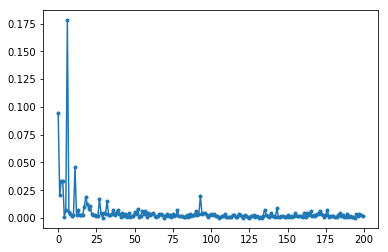

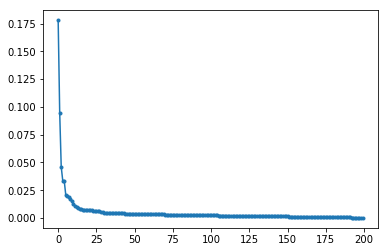

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

print(confusion_matrix(y_labels, grid_search.best_estimator_.predict(X_transformed)))
plt.plot(grid_search.best_estimator_.feature_importances_, marker='.')
plt.show()
plt.plot(sorted(grid_search.best_estimator_.feature_importances_)[::-1], marker='.')

In [17]:
y_predictions = grid_search.predict(test_transformed['X_transformed'])
print_metrics(test_transformed['y_labels'], y_predictions)

Accuracy: 0.696427111438
Precision: 0.72422277394
Recall: 0.696427111438
F1-score: 0.67031959083


In [ ]:
print "Metrics on Training Set"
print_metrics(y_labels, grid_search.predict(X_transformed))

print "Metrics on Test Set"
y_predictions = grid_search.predict(test_transformed['X_transformed'])
print_metrics(test_transformed['y_labels'], y_predictions)
print confusion_matrix(test_transformed['y_labels'], y_predictions)
plot_ROC(y_val, grid_search.predict_proba(test_transformed['X_transformed'])[:, 1])



# For reading confusion matrix, get a nice plot
#  [[TN FP]
#   [TN TP]]

# get the feature importance
# check which hyperparameters were the besta


In [ ]:
# glorot initialization?
# sigmoid vs relu
# increase dense neurons or more filters
# learning rate
# want to overfit; ideally should be more accurate than 50%

In [4]:
%%time

LeNet = get_LeNet_model()
LeNet.optimizer.lr = 0.1
LeNet.fit_generator(train_batches, train_batches.N // 10, nb_epoch=1, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/1
3648/3696 [============================>.] - ETA: 0s - loss: 0.9257 - acc: 0.5400

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1462: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


3712/3696 [==============================] - 205s - loss: 0.9215 - acc: 0.5412 - val_loss: 0.7204 - val_acc: 0.5621
CPU times: user 3min 24s, sys: 15.7 s, total: 3min 40s
Wall time: 3min 29s


In [5]:
%%time

LeNet.optimizer.lr = 0.1
LeNet.fit_generator(train_batches, train_batches.N // 10, nb_epoch=1, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/1
3712/3696 [==============================] - 190s - loss: 0.7125 - acc: 0.5348 - val_loss: 0.6930 - val_acc: 0.5621
CPU times: user 3min 21s, sys: 14.5 s, total: 3min 35s
Wall time: 3min 10s


In [15]:
#LeNet.predict(train_batches.next()[0])

array([[ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5806,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5806,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5806,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5806,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5806,  0